# ニューラルネットワーク

## 手書き数字の分類(MNIST)

### データセット

In [1]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (70000, 784)
y shape: (70000,)


In [2]:
X = ((X / 255.0)-0.5) * 2.0  # Normalize to [-1, 1]　最適化が安定する。

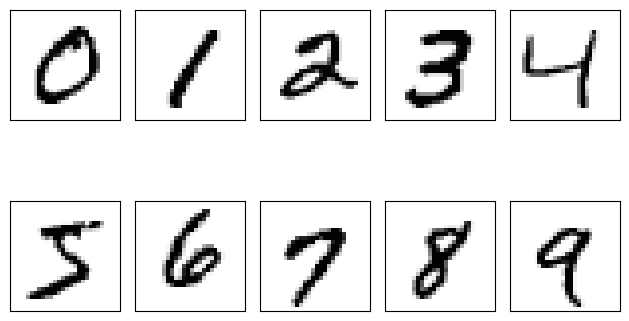

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

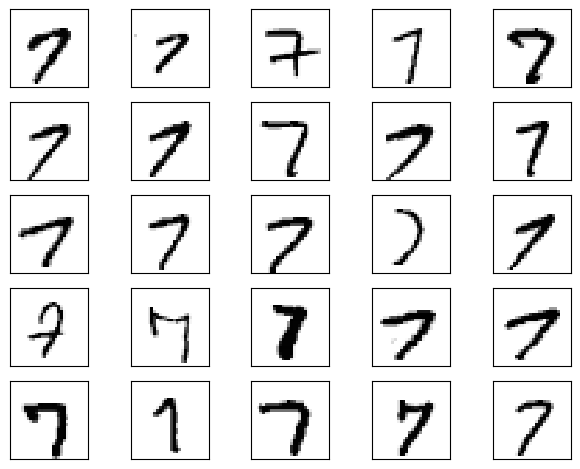

In [4]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_7.png', dpi=300)
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

### モデル

In [6]:
from neuralnet import NeuralNetMLP, int_to_onehot
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

In [7]:
import numpy as np
num_epochs = 50
minibatch_size = 100
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, X.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

In [8]:
# 訓練時と同じエポック数にわたって処理を繰り返す
for i in range(num_epochs):
    # ジェネレーター関数によりジェネレータ-オブジェクトを生成。yield
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen: # for文ごとにnext()が呼ばれる
        break
    break

# print(next(minibatch_gen))  # ジェネレータ-オブジェクトの中身を確認
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [9]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += np.sum(predicted_labels == targets)
        num_examples += features.shape[0]
        mse += loss
    mse = mse/i
    acc = correct_pred / num_examples
    return mse, acc

In [10]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print("Validation MSE:", mse)
print("Validation accuracy:", acc)

Validation MSE: 0.2762538570667145
Validation accuracy: 0.0936


In [15]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            # 出力を計算
            a_h, a_out = model.forward(X_train_mini)
            # 勾配を計算
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini, a_h, a_out, y_train_mini)
            # 重みを更新
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        # エポックの記録
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f"Epoch {e+1:03d}/{num_epochs:03d} "
              f"| Train MSE: {train_mse:.2f} "
              f"| Train Acc: {train_acc:.2f}% "
              f"| Valid Acc: {valid_acc:.2f}%")
        
    return epoch_loss, epoch_train_acc, epoch_valid_acc

### 学習

In [16]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1)

Epoch 001/050 | Train MSE: 0.02 | Train Acc: 87.97% | Valid Acc: 87.60%
Epoch 002/050 | Train MSE: 0.02 | Train Acc: 89.22% | Valid Acc: 89.16%
Epoch 003/050 | Train MSE: 0.02 | Train Acc: 90.07% | Valid Acc: 89.94%
Epoch 004/050 | Train MSE: 0.02 | Train Acc: 90.72% | Valid Acc: 90.46%
Epoch 005/050 | Train MSE: 0.02 | Train Acc: 91.20% | Valid Acc: 90.94%
Epoch 006/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.12%
Epoch 007/050 | Train MSE: 0.01 | Train Acc: 91.80% | Valid Acc: 91.50%
Epoch 008/050 | Train MSE: 0.01 | Train Acc: 92.02% | Valid Acc: 91.68%
Epoch 009/050 | Train MSE: 0.01 | Train Acc: 92.32% | Valid Acc: 92.06%
Epoch 010/050 | Train MSE: 0.01 | Train Acc: 92.53% | Valid Acc: 92.32%
Epoch 011/050 | Train MSE: 0.01 | Train Acc: 92.71% | Valid Acc: 92.42%
Epoch 012/050 | Train MSE: 0.01 | Train Acc: 92.87% | Valid Acc: 92.54%
Epoch 013/050 | Train MSE: 0.01 | Train Acc: 92.97% | Valid Acc: 92.74%
Epoch 014/050 | Train MSE: 0.01 | Train Acc: 93.13% | Valid Acc:

### 評価

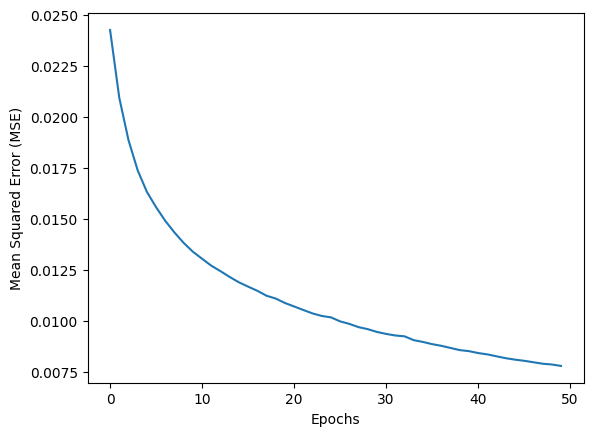

In [17]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.show()

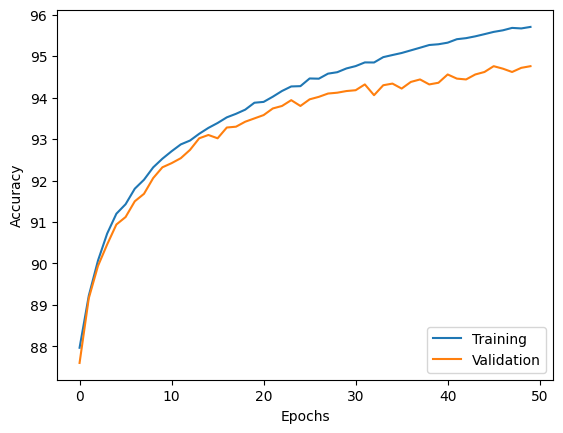

In [18]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()

In [19]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc * 100:.2f}%')

Test accuracy: 94.61%


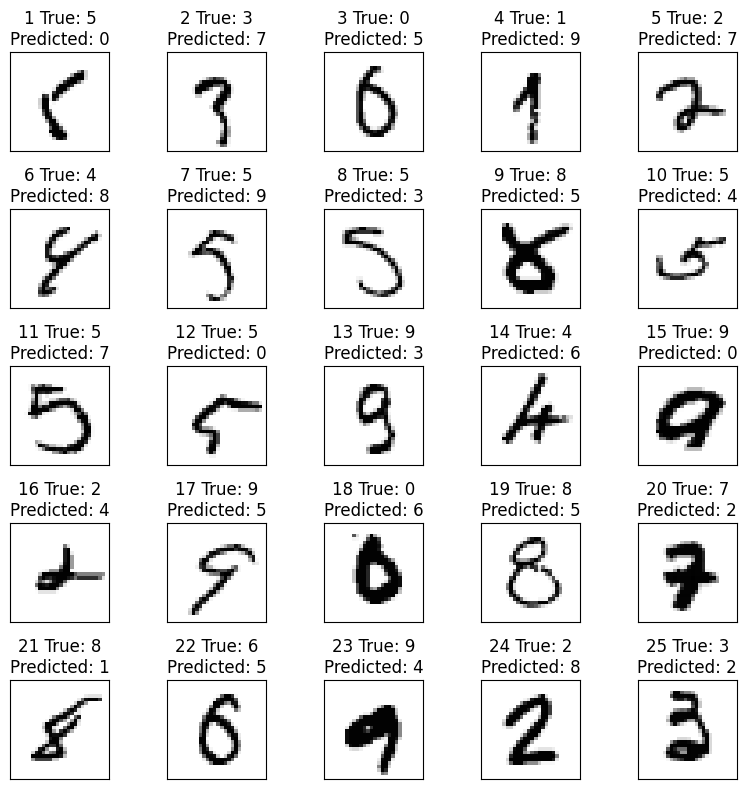

In [21]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_image = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_image[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1} '
                    f'True: {correct_labels[i]}\n'
                    f'Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_misclassified.png', dpi=300)
plt.show()